<a href="https://colab.research.google.com/github/ahatesham02/Artificial_Neural_Network-ANN-/blob/main/Assignment__FGSM_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from collections import defaultdict
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.8.0+cu126
TorchVision version: 0.23.0+cu126
Using device: cuda


## Load MNIST and CIFAR-10 datasets

In [2]:
def get_datasets():
    """"""

    mnist_transform_train = transforms.Compose([
        transforms.ToTensor(),                     # converts PIL images to pytorch tensors
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST normalization (mean=0.1307, std=0.3081 are standard values)
    ])

    mnist_transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # CIFAR-10 normalization (ImageNet stats commonly used)
    cifar_transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),         # with data augmentation
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    cifar_transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Load datasets
    mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform_train)
    mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform_test)

    cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform_train)
    cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform_test)

    return mnist_train, mnist_test, cifar_train, cifar_test

## Vision Transformer Implementation

#### https://arxiv.org/abs/2010.11929

In [3]:
# Converts an image into a sequence of patch embeddings to “tokens” for the Transformer.
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x


In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, n_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, n_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, n_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)

        mlp_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x)) # residual connection
        x = x + self.mlp(self.norm2(x))
        return x


In [6]:

"""class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=192, n_layers=6, n_heads=3, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        # Class token and positional embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, mlp_ratio, dropout)
            for _ in range(n_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = self.head(x[:, 0])  # Use cls token
        return x

In [22]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=192, n_layers=6, n_heads=3, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        # Class token and positional embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Fix: Make sure positional embedding matches the number of patches + 1 (for cls token)
        num_patches = self.patch_embed.n_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, mlp_ratio, dropout)
            for _ in range(n_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Initialize weights properly"""
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Ensure positional embedding size matches
        if x.size(1) != self.pos_embed.size(1):
            print(f"Size mismatch: x.size(1)={x.size(1)}, pos_embed.size(1)={self.pos_embed.size(1)}")
            return None

        x = x + self.pos_embed
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = self.head(x[:, 0])  # Use cls token
        return x


## Resnet18 Model

In [23]:
def create_resnet18(num_classes, input_channels=3, input_size=32):
    """Create ResNet-18 model adapted for small images"""
    model = resnet18(pretrained=False, num_classes=num_classes)

    # Modify first conv layer for different input channels
    if input_channels != 3:
        model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # For small images (MNIST 28x28, CIFAR-10 32x32), modify the first conv layer
    if input_size <= 32:
        model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()  # Remove maxpool for small images

    return model


## ViT Model


In [24]:
def create_vit(num_classes, img_size, input_channels):
    if img_size == 28:  # MNIST
        return VisionTransformer(
            img_size=28, patch_size=4, in_channels=input_channels,
            num_classes=num_classes, embed_dim=128, n_layers=4, n_heads=4
        )
    else:  # CIFAR-10
        return VisionTransformer(
            img_size=32, patch_size=4, in_channels=input_channels,
            num_classes=num_classes, embed_dim=192, n_layers=6, n_heads=3
        )


## FGSM Attack

Untargeted : x' = x + ε ⋅ sign(∇ₓ J(θ, x, y))
Targeted : x' = x - ε ⋅ sign(∇ₓ J(θ, x, yₜ))

In [25]:
def fgsm_attack(model, data, target, epsilon, targeted=False, data_mean=None, data_std=None):
    """
    Implements Fast Gradient Sign Method (FGSM) attack

    Args:
        model: Neural network model
        data: Input data tensor (normalized)
        target: Target labels
        epsilon: Attack strength
        targeted: If True, performs targeted attack; if False, untargeted
        data_mean: Mean used for normalization (for clipping)
        data_std: Std used for normalization (for clipping)

    Returns:
        Adversarial examples
    """
    # Create a copy of data that requires gradient
    data = data.clone().detach().requires_grad_(True)

    # Forward pass
    output = model(data)

    # Calculate loss
    if targeted:
        # For targeted attack, minimize loss w.r.t. target class
        loss = F.cross_entropy(output, target)
        loss_grad_sign = -1
    else:
        # For untargeted attack, maximize loss w.r.t. true class
        loss = F.cross_entropy(output, target)
        loss_grad_sign = 1

    # Backward pass
    model.zero_grad()
    if data.grad is not None:
        data.grad.zero_()
    loss.backward()

    # Collect gradients
    data_grad = data.grad

    # Handle case where gradient is None
    if data_grad is None:
        print("Warning: Gradient is None, returning original data")
        return data.clone().detach()

    # Create adversarial examples
    sign_data_grad = data_grad.sign()
    perturbed_data = data + loss_grad_sign * epsilon * sign_data_grad

    # Clip to maintain valid range after normalization
    if data_mean is not None and data_std is not None:
        # Convert normalized bounds back to [0,1] space for clipping
        if len(data_mean) == 1:  # MNIST
            min_val = (0 - data_mean[0]) / data_std[0]
            max_val = (1 - data_mean[0]) / data_std[0]
        else:  # CIFAR-10
            min_val = torch.tensor([(0 - data_mean[i]) / data_std[i] for i in range(3)]).view(1, 3, 1, 1).to(data.device)
            max_val = torch.tensor([(1 - data_mean[i]) / data_std[i] for i in range(3)]).view(1, 3, 1, 1).to(data.device)

        perturbed_data = torch.clamp(perturbed_data, min_val, max_val)

    return perturbed_data.detach()

## Training

In [26]:
def train_model(model, train_loader, num_epochs=10, lr=0.001, model_name="ResNet"):
    """Train a model"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Adjust learning rate for different models
    if "ViT" in model_name:
        # ViT often benefits from slightly higher learning rate and different optimizer
        optimizer = optim.AdamW(model.parameters(), lr=lr*1.5, weight_decay=1e-3)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    else:
        # ResNet
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, num_epochs//3), gamma=0.5)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_postfix({
                'Loss': f'{running_loss/len(pbar):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        scheduler.step()
        print(f'Epoch {epoch+1}: Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100.*correct/total:.2f}%')

    return model

In [27]:
# Test
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

## Evaluation

In [28]:
def evaluate_attacks(model, test_loader, epsilons, num_samples=1000, dataset_name="MNIST"):
    """Evaluate FGSM attacks with different epsilon values"""
    model.eval()

    # Get fixed subset of test data
    test_data = []
    test_targets = []
    for i, (data, target) in enumerate(test_loader):
        if i * test_loader.batch_size >= num_samples:
            break
        test_data.append(data)
        test_targets.append(target)

    # Concatenate and take first num_samples
    test_data = torch.cat(test_data, dim=0)[:num_samples]
    test_targets = torch.cat(test_targets, dim=0)[:num_samples]

    results = defaultdict(dict)

    # Clean accuracy
    with torch.no_grad():
        test_data_gpu = test_data.to(device)
        test_targets_gpu = test_targets.to(device)
        clean_output = model(test_data_gpu)
        clean_pred = clean_output.argmax(dim=1)
        clean_correct = (clean_pred == test_targets_gpu).float().mean().item()
        results['clean_accuracy'] = clean_correct * 100

    # For each epsilon
    for epsilon in epsilons:
        eps_val = epsilon / 255.0
        print(f"Evaluating epsilon = {epsilon}/255 = {eps_val:.4f}")

        # Untargeted attack
        adversarial_data = fgsm_attack(model, test_data.to(device), test_targets.to(device), eps_val, targeted=False)

        with torch.no_grad():
            adv_output = model(adversarial_data)
            adv_pred = adv_output.argmax(dim=1)
            robust_correct = (adv_pred == test_targets.to(device)).float().mean().item()

        results[f'robust_acc_{epsilon}'] = robust_correct * 100
        results[f'asr_untargeted_{epsilon}'] = (1 - robust_correct) * 100

        # Targeted attacks
        # Random target
        random_targets = torch.randint(0, clean_output.size(1), (len(test_targets),))
        # Ensure random targets are different from true labels
        mask = random_targets == test_targets
        random_targets[mask] = (random_targets[mask] + 1) % clean_output.size(1)

        targeted_adv_random = fgsm_attack(model, test_data.to(device), random_targets.to(device), eps_val, targeted=True)

        with torch.no_grad():
            targeted_output_random = model(targeted_adv_random)
            targeted_pred_random = targeted_output_random.argmax(dim=1)
            targeted_success_random = (targeted_pred_random == random_targets.to(device)).float().mean().item()

        results[f'targeted_asr_random_{epsilon}'] = targeted_success_random * 100

        # Least-likely class target
        with torch.no_grad():
            clean_logits = model(test_data.to(device))
            least_likely_targets = clean_logits.argmin(dim=1)

        targeted_adv_ll = fgsm_attack(model, test_data.to(device), least_likely_targets, eps_val, targeted=True)

        with torch.no_grad():
            targeted_output_ll = model(targeted_adv_ll)
            targeted_pred_ll = targeted_output_ll.argmin(dim=1)
            targeted_success_ll = (targeted_pred_ll == least_likely_targets).float().mean().item()

        results[f'targeted_asr_least_likely_{epsilon}'] = targeted_success_ll * 100

    return results, test_data, test_targets


In [29]:
def denormalize(tensor, mean, std):
    """Denormalize tensor for visualization"""
    if len(mean) == 1:  # MNIST
        return tensor * std[0] + mean[0]
    else:  # CIFAR-10
        for i in range(3):
            tensor[:, i, :, :] = tensor[:, i, :, :] * std[i] + mean[i]
    return tensor

## Visualization

In [30]:
def visualize_attacks(model, test_data, test_targets, epsilon=8, num_examples=10, dataset_name="", model_name=""):
    """Visualize original, perturbation, and adversarial examples"""
    model.eval()
    eps_val = epsilon / 255.0

    # Define normalization parameters
    if dataset_name == "MNIST":
        data_mean = [0.1307]
        data_std = [0.3081]
    else:  # CIFAR-10
        data_mean = [0.4914, 0.4822, 0.4465]
        data_std = [0.2023, 0.1994, 0.2010]

    # Select random examples
    indices = np.random.choice(len(test_data), num_examples, replace=False)
    examples_data = test_data[indices].to(device)
    examples_targets = test_targets[indices].to(device)

    # Generate adversarial examples
    adv_data = fgsm_attack(model, examples_data, examples_targets, eps_val,
                          targeted=False, data_mean=data_mean, data_std=data_std)

    # Calculate perturbations in normalized space
    perturbations_norm = (adv_data - examples_data) * 10  # Scale for visibility

    # Denormalize for visualization
    examples_data_vis = denormalize(examples_data.clone(), data_mean, data_std)
    adv_data_vis = denormalize(adv_data.clone(), data_mean, data_std)

    # Clamp to [0, 1] for display
    examples_data_vis = torch.clamp(examples_data_vis, 0, 1)
    adv_data_vis = torch.clamp(adv_data_vis, 0, 1)

    # Get predictions
    with torch.no_grad():
        orig_preds = model(examples_data).softmax(dim=1)
        adv_preds = model(adv_data).softmax(dim=1)
        orig_classes = orig_preds.argmax(dim=1)
        adv_classes = adv_preds.argmax(dim=1)
        orig_conf = orig_preds.max(dim=1)[0]
        adv_conf = adv_preds.max(dim=1)[0]

    # Plot
    fig, axes = plt.subplots(3, num_examples, figsize=(num_examples * 2, 6))
    fig.suptitle(f'{dataset_name} - {model_name} - FGSM Attack (ε={epsilon}/255)', fontsize=14)

    for i in range(num_examples):
        # Original
        if examples_data.size(1) == 1:  # Grayscale
            axes[0, i].imshow(examples_data_vis[i].cpu().squeeze(), cmap='gray')
        else:  # RGB
            axes[0, i].imshow(examples_data_vis[i].cpu().permute(1, 2, 0))
        axes[0, i].set_title(f'Original\nClass: {orig_classes[i].item()}\nConf: {orig_conf[i].item():.2f}')
        axes[0, i].axis('off')

        # Perturbation (scaled)
        if perturbations_norm.size(1) == 1:  # Grayscale
            axes[1, i].imshow(perturbations_norm[i].cpu().squeeze(), cmap='seismic', vmin=-1, vmax=1)
        else:  # RGB
            pert_vis = perturbations_norm[i].cpu().permute(1, 2, 0)
            # Normalize for visualization
            pert_vis = (pert_vis - pert_vis.min()) / (pert_vis.max() - pert_vis.min())
            axes[1, i].imshow(pert_vis)
        axes[1, i].set_title('Perturbation\n(×10)')
        axes[1, i].axis('off')

        # Adversarial
        if adv_data.size(1) == 1:  # Grayscale
            axes[2, i].imshow(adv_data_vis[i].cpu().squeeze(), cmap='gray')
        else:  # RGB
            axes[2, i].imshow(adv_data_vis[i].cpu().permute(1, 2, 0))
        axes[2, i].set_title(f'Adversarial\nClass: {adv_classes[i].item()}\nConf: {adv_conf[i].item():.2f}')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()


=== FGSM White-Box Attack Evaluation ===

Loading datasets...

Dataset: MNIST

--- ResNet-18 on MNIST ---
Training ResNet-18...


Epoch 1/3: 100%|██████████| 938/938 [00:56<00:00, 16.57it/s, Loss=0.1024, Acc=96.75%]


Epoch 1: Loss: 0.1024, Accuracy: 96.75%


Epoch 2/3: 100%|██████████| 938/938 [00:55<00:00, 16.80it/s, Loss=0.0401, Acc=98.80%]


Epoch 2: Loss: 0.0401, Accuracy: 98.80%


Epoch 3/3: 100%|██████████| 938/938 [00:56<00:00, 16.67it/s, Loss=0.0244, Acc=99.25%]


Epoch 3: Loss: 0.0244, Accuracy: 99.25%
Test Accuracy: 99.38%
Evaluating FGSM attacks...
Evaluating epsilon = 1/255 = 0.0039
Evaluating epsilon = 2/255 = 0.0078
Evaluating epsilon = 4/255 = 0.0157
Evaluating epsilon = 8/255 = 0.0314
Generating visualizations...


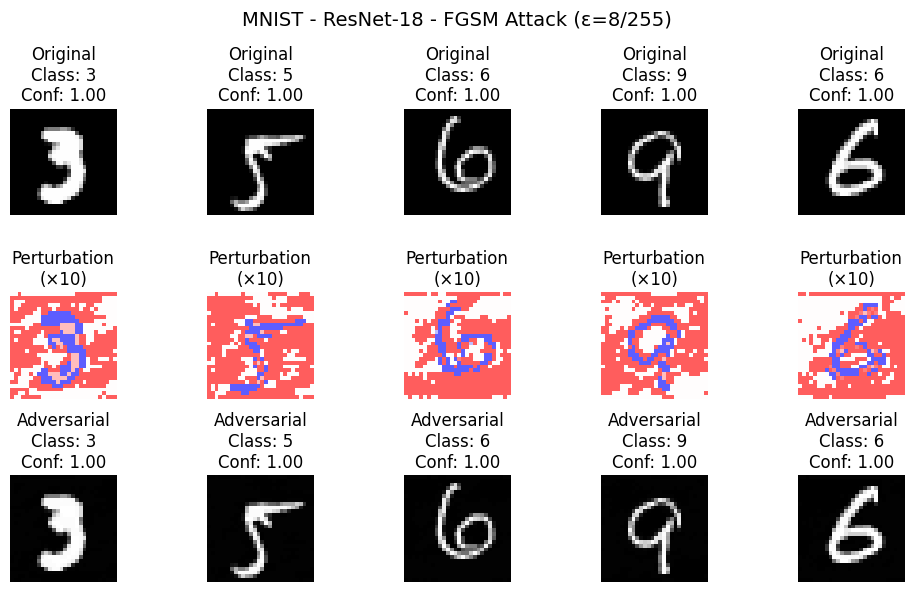


--- ViT on MNIST ---
Training ViT...


Epoch 1/6: 100%|██████████| 938/938 [00:24<00:00, 38.00it/s, Loss=1.0206, Acc=62.91%]


Epoch 1: Loss: 1.0206, Accuracy: 62.91%


Epoch 2/6: 100%|██████████| 938/938 [00:24<00:00, 37.74it/s, Loss=0.4075, Acc=86.89%]


Epoch 2: Loss: 0.4075, Accuracy: 86.89%


Epoch 3/6: 100%|██████████| 938/938 [00:24<00:00, 38.16it/s, Loss=0.2894, Acc=90.83%]


Epoch 3: Loss: 0.2894, Accuracy: 90.83%


Epoch 4/6: 100%|██████████| 938/938 [00:24<00:00, 38.42it/s, Loss=0.2253, Acc=92.80%]


Epoch 4: Loss: 0.2253, Accuracy: 92.80%


Epoch 5/6: 100%|██████████| 938/938 [00:24<00:00, 38.02it/s, Loss=0.1724, Acc=94.46%]


Epoch 5: Loss: 0.1724, Accuracy: 94.46%


Epoch 6/6: 100%|██████████| 938/938 [00:25<00:00, 36.68it/s, Loss=0.1368, Acc=95.63%]


Epoch 6: Loss: 0.1368, Accuracy: 95.63%
Test Accuracy: 96.07%
Evaluating FGSM attacks...
Evaluating epsilon = 1/255 = 0.0039
Evaluating epsilon = 2/255 = 0.0078
Evaluating epsilon = 4/255 = 0.0157
Evaluating epsilon = 8/255 = 0.0314
Generating visualizations...


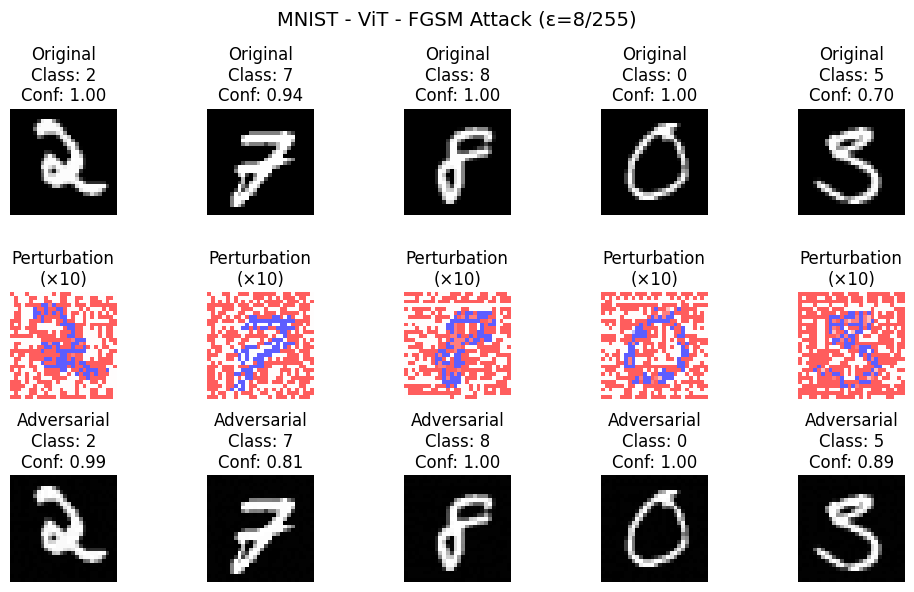


Dataset: CIFAR-10

--- ResNet-18 on CIFAR-10 ---
Training ResNet-18...


Epoch 1/5: 100%|██████████| 782/782 [01:00<00:00, 12.99it/s, Loss=1.3840, Acc=49.44%]


Epoch 1: Loss: 1.3840, Accuracy: 49.44%


Epoch 2/5: 100%|██████████| 782/782 [00:59<00:00, 13.05it/s, Loss=0.8758, Acc=68.93%]


Epoch 2: Loss: 0.8758, Accuracy: 68.93%


Epoch 3/5: 100%|██████████| 782/782 [00:59<00:00, 13.15it/s, Loss=0.6636, Acc=76.81%]


Epoch 3: Loss: 0.6636, Accuracy: 76.81%


Epoch 4/5: 100%|██████████| 782/782 [00:59<00:00, 13.14it/s, Loss=0.5315, Acc=81.48%]


Epoch 4: Loss: 0.5315, Accuracy: 81.48%


Epoch 5/5: 100%|██████████| 782/782 [00:59<00:00, 13.22it/s, Loss=0.4552, Acc=84.20%]


Epoch 5: Loss: 0.4552, Accuracy: 84.20%
Test Accuracy: 83.99%
Evaluating FGSM attacks...
Evaluating epsilon = 1/255 = 0.0039
Evaluating epsilon = 2/255 = 0.0078
Evaluating epsilon = 4/255 = 0.0157
Evaluating epsilon = 8/255 = 0.0314
Generating visualizations...


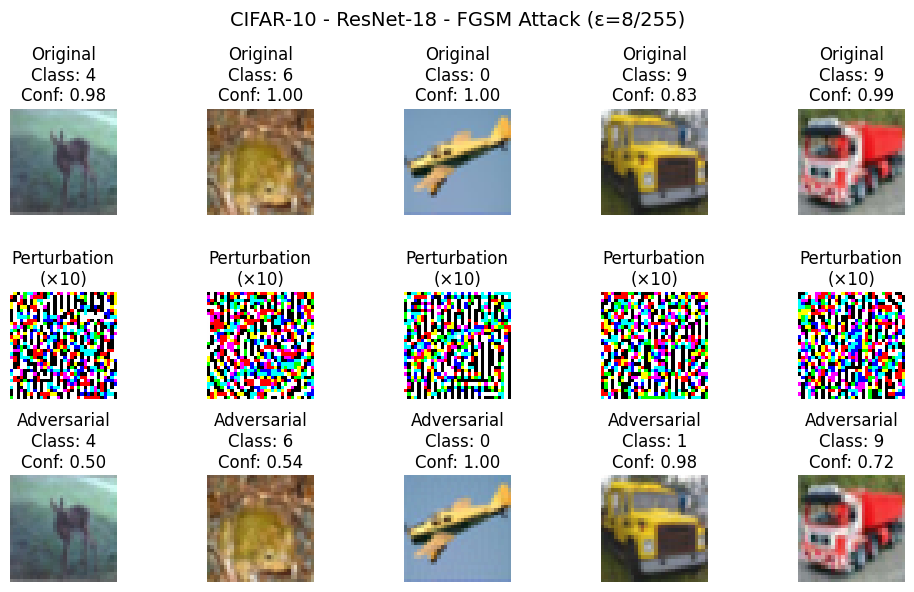


--- ViT on CIFAR-10 ---
Training ViT...


Epoch 1/12: 100%|██████████| 782/782 [00:47<00:00, 16.56it/s, Loss=2.0502, Acc=21.57%]


Epoch 1: Loss: 2.0502, Accuracy: 21.57%


Epoch 2/12: 100%|██████████| 782/782 [00:46<00:00, 16.73it/s, Loss=1.9966, Acc=23.42%]


Epoch 2: Loss: 1.9966, Accuracy: 23.42%


Epoch 3/12: 100%|██████████| 782/782 [00:46<00:00, 16.87it/s, Loss=1.9485, Acc=25.34%]


Epoch 3: Loss: 1.9485, Accuracy: 25.34%


Epoch 4/12: 100%|██████████| 782/782 [00:46<00:00, 16.69it/s, Loss=1.9136, Acc=27.21%]


Epoch 4: Loss: 1.9136, Accuracy: 27.21%


Epoch 5/12: 100%|██████████| 782/782 [00:46<00:00, 16.94it/s, Loss=1.8939, Acc=28.09%]


Epoch 5: Loss: 1.8939, Accuracy: 28.09%


Epoch 6/12: 100%|██████████| 782/782 [00:46<00:00, 16.80it/s, Loss=1.8546, Acc=29.75%]


Epoch 6: Loss: 1.8546, Accuracy: 29.75%


Epoch 7/12: 100%|██████████| 782/782 [00:46<00:00, 16.81it/s, Loss=1.8349, Acc=30.71%]


Epoch 7: Loss: 1.8349, Accuracy: 30.71%


Epoch 8/12: 100%|██████████| 782/782 [00:46<00:00, 16.94it/s, Loss=1.8106, Acc=31.50%]


Epoch 8: Loss: 1.8106, Accuracy: 31.50%


Epoch 9/12: 100%|██████████| 782/782 [00:46<00:00, 16.73it/s, Loss=1.7870, Acc=33.15%]


Epoch 9: Loss: 1.7870, Accuracy: 33.15%


Epoch 10/12: 100%|██████████| 782/782 [00:46<00:00, 16.67it/s, Loss=1.7608, Acc=34.06%]


Epoch 10: Loss: 1.7608, Accuracy: 34.06%


Epoch 11/12: 100%|██████████| 782/782 [00:47<00:00, 16.62it/s, Loss=1.7403, Acc=34.82%]


Epoch 11: Loss: 1.7403, Accuracy: 34.82%


Epoch 12/12: 100%|██████████| 782/782 [00:47<00:00, 16.62it/s, Loss=1.7354, Acc=35.12%]


Epoch 12: Loss: 1.7354, Accuracy: 35.12%
Test Accuracy: 35.57%
Evaluating FGSM attacks...
Evaluating epsilon = 1/255 = 0.0039
Evaluating epsilon = 2/255 = 0.0078
Evaluating epsilon = 4/255 = 0.0157
Evaluating epsilon = 8/255 = 0.0314
Generating visualizations...


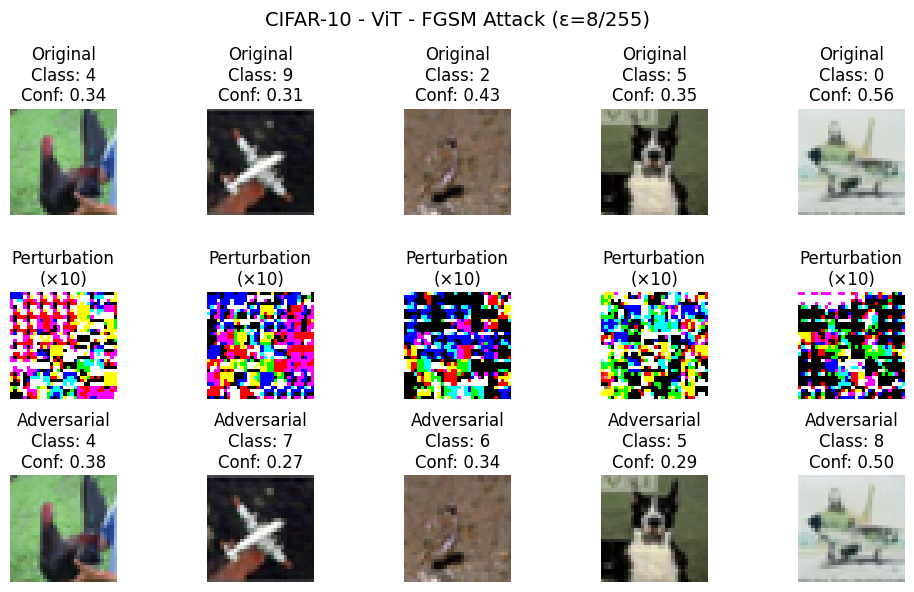


RESULTS SUMMARY

MNIST_ResNet-18:
Clean Accuracy: 99.20%
ε = 1/255:
  Robust Accuracy: 99.10%
  ASR (Untargeted): 0.90%
  ASR (Random Target): 0.00%
  ASR (Least-Likely): 99.10%
ε = 2/255:
  Robust Accuracy: 99.00%
  ASR (Untargeted): 1.00%
  ASR (Random Target): 0.10%
  ASR (Least-Likely): 98.00%
ε = 4/255:
  Robust Accuracy: 99.00%
  ASR (Untargeted): 1.00%
  ASR (Random Target): 0.00%
  ASR (Least-Likely): 96.50%
ε = 8/255:
  Robust Accuracy: 98.90%
  ASR (Untargeted): 1.10%
  ASR (Random Target): 0.20%
  ASR (Least-Likely): 92.60%

MNIST_ViT:
Clean Accuracy: 95.30%
ε = 1/255:
  Robust Accuracy: 94.20%
  ASR (Untargeted): 5.80%
  ASR (Random Target): 0.80%
  ASR (Least-Likely): 92.00%
ε = 2/255:
  Robust Accuracy: 92.80%
  ASR (Untargeted): 7.20%
  ASR (Random Target): 0.70%
  ASR (Least-Likely): 85.40%
ε = 4/255:
  Robust Accuracy: 90.60%
  ASR (Untargeted): 9.40%
  ASR (Random Target): 0.90%
  ASR (Least-Likely): 73.80%
ε = 8/255:
  Robust Accuracy: 85.30%
  ASR (Untargeted): 14.

In [31]:
def main():
    """Main function to run all experiments"""
    print("=== FGSM White-Box Attack Evaluation ===\n")

    # Parameters
    epsilons = [1, 2, 4, 8]  # Will be divided by 255
    batch_size = 64
    num_eval_samples = 1000

    # Load datasets
    print("Loading datasets...")
    mnist_train, mnist_test, cifar_train, cifar_test = get_datasets()

    # Create data loaders
    mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
    cifar_train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True)
    cifar_test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)

    # Results storage
    all_results = {}

    # Dataset configurations
    datasets = [
        ("MNIST", mnist_train_loader, mnist_test_loader, 1, 28, 10),
        ("CIFAR-10", cifar_train_loader, cifar_test_loader, 3, 32, 10)
    ]

    for dataset_name, train_loader, test_loader, channels, img_size, num_classes in datasets:
        print(f"\n{'='*50}")
        print(f"Dataset: {dataset_name}")
        print(f"{'='*50}")

        # Model configurations
        models_config = [
            ("ResNet-18", lambda: create_resnet18(num_classes, channels, img_size)),
            ("ViT", lambda: create_vit(num_classes, img_size, channels))
        ]

        for model_name, model_creator in models_config:
            print(f"\n--- {model_name} on {dataset_name} ---")

            # Create and train model
            model = model_creator()
            print(f"Training {model_name}...")

            # Adjust epochs based on model and dataset
            if model_name == "ViT":
                # ViT needs significantly more epochs, especially for CIFAR-10
                num_epochs = 12 if dataset_name == "CIFAR-10" else 6
            else:  # ResNet-18
                num_epochs = 5 if dataset_name == "CIFAR-10" else 3

            model = train_model(model, train_loader, num_epochs=num_epochs, model_name=model_name)

            # Test clean accuracy
            clean_acc = test_model(model, test_loader)

            # Evaluate attacks
            print("Evaluating FGSM attacks...")
            results, test_data, test_targets = evaluate_attacks(model, test_loader, epsilons, num_eval_samples, dataset_name)

            # Store results
            all_results[f"{dataset_name}_{model_name}"] = results

            # Visualize attacks
            print("Generating visualizations...")
            visualize_attacks(model, test_data, test_targets, epsilon=8,
                            num_examples=5, dataset_name=dataset_name, model_name=model_name)

    # Print results table
    print("\n" + "="*80)
    print("RESULTS SUMMARY")
    print("="*80)

    for key, results in all_results.items():
        print(f"\n{key}:")
        print(f"Clean Accuracy: {results['clean_accuracy']:.2f}%")

        for eps in epsilons:
            print(f"ε = {eps}/255:")
            print(f"  Robust Accuracy: {results[f'robust_acc_{eps}']:.2f}%")
            print(f"  ASR (Untargeted): {results[f'asr_untargeted_{eps}']:.2f}%")
            print(f"  ASR (Random Target): {results[f'targeted_asr_random_{eps}']:.2f}%")
            print(f"  ASR (Least-Likely): {results[f'targeted_asr_least_likely_{eps}']:.2f}%")

if __name__ == "__main__":
    main()